# Chapter 11: Training Deep Learning Neural Nets
-----
-----

Difficulties and Problems, using what we saw in ch10:
- Vanishing gradient, exploding gradients
- slow to train
- risk of overfitting when a model number of parameters is very large

## Vanishing/Exploding Gradient Problem
-----

Gradients get smaller and smaller as algorithm progresses down to lower layers, resulting in unchanged weights in those layers, so it never converges to good solution.

The opposite can happen gradients grow larger, causing the algorithm to diverge,

The problem with vanishing gradients was found to be linked to the use of the sigmoid activation function and initializing the weight with a random values form a normal distribution with mean of 0 and standard deviation of 1.
- variance of output much greater than that of the inputs layers.
- going forward in the network, increases the variance at each layer causing the sigmoid to saturate(0 and 1)
- when staturation happens, the gradient approaches 0

#### Xavier and He Initialization
Need variance of input to be equal to output layers, and gradients must have equal variance before and after flowing through a layer in reverse direction.

Weight initialized with:
- Normal Distribution: mean of 0 and standard deviation $\sigma = \sqrt{\frac{2} {n_{inputs} + n_{outputs}}}$
- or Uniform Distribution: between -r and +r with $r = \sqrt{\frac{6} {n_{inputs} + n_{outputs}}}$

using Xavier's strategy can speed up training. There are different strategies for different activation functions see page.278

#### Nonsaturating Activation Functions
Using ReLU in deep nets preform better, but have the probelm of `dying ReLU`: in traing some of the neurons die, the only output zeros.

Using leaky ReLU can solve this.

But using an `exponential linear unit`(ELU) seems to out-preform all ReLU varients.([2015 Paper](http://goo.gl/Sdl2P7))

$$ELU_{\alpha}(z) = \[ \left \{ \begin{tabular}{cc} \alpha( exp(x) -1 ) & if z \textless 0 \\z & if z \geq 0 \end{tabular} \]$$
http://quicklatex.com/cache3/e8/ql_2e08af9d00f36490ed605dc0f63200e8_l3.png

In [1]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Common imports
import numpy as np

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

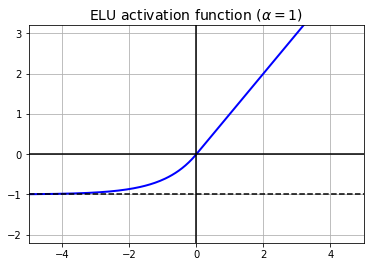

In [2]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Main drawback, slower to compute than ReLU, but faster to train so it compensates.

In [3]:
import tensorflow as tf

# leaky relu

def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")


In [4]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

#### Batch Normalization

Addign operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameter per layers.

- achives same accuracy using less training steps
- act like a regularizer
- speeds up training
- less sensitive to weight initilization
- vanishing gradient problem reduced
- adds complexity to the model

##### Implementing Batch Normalization with Tensorflow
function is provided `batch_normalization()`

In [6]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [7]:
reset_graph()

###############
# To avoid repeating the same parameters over and over again, we can use Python's partial() function:
###############

from functools import partial
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')
my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [8]:
# build a net with ELU and batch normalization

reset_graph()

batch_norm_momentum = 0.9
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, 60, name="hidden3")
    bn3 = tf.nn.elu(my_batch_norm_layer(hidden3))
    hidden4 = my_dense_layer(bn3, 30, name="hidden4")
    bn4 = tf.nn.elu(my_batch_norm_layer(hidden4))
    logits_before_bn = my_dense_layer(bn4, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
n_epochs = 200
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "tmp_models/ch11_batchNorm_ELU.ckpt")

0 Validation accuracy: 0.9114


1 Validation accuracy: 0.9354


2 Validation accuracy: 0.9474


3 Validation accuracy: 0.9524


4 Validation accuracy: 0.9568


5 Validation accuracy: 0.9598


6 Validation accuracy: 0.9652


7 Validation accuracy: 0.9664


8 Validation accuracy: 0.9694


9 Validation accuracy: 0.9686


10 Validation accuracy: 0.9692


11 Validation accuracy: 0.9708


12 Validation accuracy: 0.9714


13 Validation accuracy: 0.9722


14 Validation accuracy: 0.9728


15 Validation accuracy: 0.9736


16 Validation accuracy: 0.9736


17 Validation accuracy: 0.974


18 Validation accuracy: 0.9752


19 Validation accuracy: 0.9758


20 Validation accuracy: 0.9768


21 Validation accuracy: 0.976


22 Validation accuracy: 0.9746


23 Validation accuracy: 0.9772


24 Validation accuracy: 0.976


25 Validation accuracy: 0.9764


26 Validation accuracy: 0.977


27 Validation accuracy: 0.9774


28 Validation accuracy: 0.9766


29 Validation accuracy: 0.978


30 Validation accuracy: 0.9792


31 Validation accuracy: 0.9778


32 Validation accuracy: 0.979


33 Validation accuracy: 0.9796


34 Validation accuracy: 0.9792


35 Validation accuracy: 0.9782


36 Validation accuracy: 0.9776


37 Validation accuracy: 0.9808


38 Validation accuracy: 0.9786


39 Validation accuracy: 0.9812


40 Validation accuracy: 0.9794


41 Validation accuracy: 0.981


42 Validation accuracy: 0.98


43 Validation accuracy: 0.9806


44 Validation accuracy: 0.9808


45 Validation accuracy: 0.981


46 Validation accuracy: 0.9806


47 Validation accuracy: 0.9802


48 Validation accuracy: 0.9796


49 Validation accuracy: 0.98


50 Validation accuracy: 0.9818


51 Validation accuracy: 0.9814


52 Validation accuracy: 0.9806


53 Validation accuracy: 0.9814


54 Validation accuracy: 0.9812


55 Validation accuracy: 0.9818


56 Validation accuracy: 0.9808


57 Validation accuracy: 0.9802


58 Validation accuracy: 0.9806


59 Validation accuracy: 0.9818


60 Validation accuracy: 0.9818


61 Validation accuracy: 0.9816


62 Validation accuracy: 0.9806


63 Validation accuracy: 0.9812


64 Validation accuracy: 0.9814


65 Validation accuracy: 0.9806


66 Validation accuracy: 0.9818


67 Validation accuracy: 0.9812


68 Validation accuracy: 0.9828


69 Validation accuracy: 0.982


70 Validation accuracy: 0.9814


71 Validation accuracy: 0.9808


72 Validation accuracy: 0.9822


73 Validation accuracy: 0.9814


74 Validation accuracy: 0.982


75 Validation accuracy: 0.9826


76 Validation accuracy: 0.9824


77 Validation accuracy: 0.9828


78 Validation accuracy: 0.9826


79 Validation accuracy: 0.9826


80 Validation accuracy: 0.9812


81 Validation accuracy: 0.9822


82 Validation accuracy: 0.9818


83 Validation accuracy: 0.9832


84 Validation accuracy: 0.9836


85 Validation accuracy: 0.983


86 Validation accuracy: 0.9816


87 Validation accuracy: 0.9826


88 Validation accuracy: 0.9822


89 Validation accuracy: 0.982


90 Validation accuracy: 0.982


91 Validation accuracy: 0.9828


92 Validation accuracy: 0.9826


93 Validation accuracy: 0.9818


94 Validation accuracy: 0.9822


95 Validation accuracy: 0.9832


96 Validation accuracy: 0.9828


97 Validation accuracy: 0.9824


98 Validation accuracy: 0.9834


99 Validation accuracy: 0.9828


100 Validation accuracy: 0.9836


101 Validation accuracy: 0.9836


102 Validation accuracy: 0.982


103 Validation accuracy: 0.982


104 Validation accuracy: 0.9836


105 Validation accuracy: 0.9828


106 Validation accuracy: 0.9826


107 Validation accuracy: 0.9822


108 Validation accuracy: 0.9832


109 Validation accuracy: 0.983


110 Validation accuracy: 0.9834


111 Validation accuracy: 0.9834


112 Validation accuracy: 0.9828


113 Validation accuracy: 0.9818


114 Validation accuracy: 0.9826


115 Validation accuracy: 0.982


116 Validation accuracy: 0.983


117 Validation accuracy: 0.9828


118 Validation accuracy: 0.9826


119 Validation accuracy: 0.982


120 Validation accuracy: 0.9822


121 Validation accuracy: 0.9834


122 Validation accuracy: 0.9832


123 Validation accuracy: 0.9828


124 Validation accuracy: 0.9836


125 Validation accuracy: 0.9834


126 Validation accuracy: 0.9826


127 Validation accuracy: 0.9832


128 Validation accuracy: 0.9826


129 Validation accuracy: 0.9818


130 Validation accuracy: 0.9834


131 Validation accuracy: 0.9832


132 Validation accuracy: 0.9832


133 Validation accuracy: 0.982


134 Validation accuracy: 0.9832


135 Validation accuracy: 0.9842


136 Validation accuracy: 0.984


137 Validation accuracy: 0.9836


138 Validation accuracy: 0.9834


139 Validation accuracy: 0.982


140 Validation accuracy: 0.9834


141 Validation accuracy: 0.9832


142 Validation accuracy: 0.9822


143 Validation accuracy: 0.9828


144 Validation accuracy: 0.9836


145 Validation accuracy: 0.9828


146 Validation accuracy: 0.9822


147 Validation accuracy: 0.9828


148 Validation accuracy: 0.983


149 Validation accuracy: 0.9828


150 Validation accuracy: 0.983


151 Validation accuracy: 0.983


152 Validation accuracy: 0.983


153 Validation accuracy: 0.9836


154 Validation accuracy: 0.9836


155 Validation accuracy: 0.9824


156 Validation accuracy: 0.9828


157 Validation accuracy: 0.9824


158 Validation accuracy: 0.9828


159 Validation accuracy: 0.9828


160 Validation accuracy: 0.9828


161 Validation accuracy: 0.982


162 Validation accuracy: 0.982


163 Validation accuracy: 0.982


164 Validation accuracy: 0.9826


165 Validation accuracy: 0.983


166 Validation accuracy: 0.9828


167 Validation accuracy: 0.9834


168 Validation accuracy: 0.9834


169 Validation accuracy: 0.9832


170 Validation accuracy: 0.983


171 Validation accuracy: 0.9834


172 Validation accuracy: 0.9828


173 Validation accuracy: 0.9826


174 Validation accuracy: 0.9842


175 Validation accuracy: 0.9828


176 Validation accuracy: 0.983


177 Validation accuracy: 0.983


178 Validation accuracy: 0.9828


179 Validation accuracy: 0.9822


180 Validation accuracy: 0.9824


181 Validation accuracy: 0.9824


182 Validation accuracy: 0.9828


183 Validation accuracy: 0.9826


184 Validation accuracy: 0.9834


185 Validation accuracy: 0.984


186 Validation accuracy: 0.9832


187 Validation accuracy: 0.983


188 Validation accuracy: 0.983


189 Validation accuracy: 0.983


190 Validation accuracy: 0.9838


191 Validation accuracy: 0.9838


192 Validation accuracy: 0.9824


193 Validation accuracy: 0.9842


194 Validation accuracy: 0.9828


195 Validation accuracy: 0.9838


196 Validation accuracy: 0.9834


197 Validation accuracy: 0.9838


198 Validation accuracy: 0.983


199 Validation accuracy: 0.9844


#### Gradient Clipping

Simply clip gradients during backprop, hyperparameter threshold can be tune.

In [11]:

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

## Reusing Pretrained Layers
-----

Using the lower layers of an existing network that solved a similar problem , speeds up training and requires less data. (transfer learning)

#### Reusing a TensorFlow Model


In [ ]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

#### Reusing Models from Other Frameworks

#### Freezing the lower Layers
Likely that lower layers in first DNN have learned low level features that will be useful across both image classification taks.


In [ ]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
training_op = optimizer.minimize(loss, var_list=train_vars)

#### Caching the Frozen Layers

#### Tweaking, Dropping, or Replacing the Upper Layers
Output layer should be replaced. upper hidden layer are likely not to be useful.

#### Model Zoos
search for tensorflow models which have been train one similar tasks that you are trying to achieve.

#### Unsupervised Pretraining
using RBM or autoencoders

#### Pretraining on an Auxiliary Task


## Faster Optimizers
-----

- Momentum Optimization
- Nesterov accelerated gradient
- AdaGrad
- RMSProp
- Adam Optimization(always use)


In [ ]:
# Momentum Optimization
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

# Nesterov accelerated gradient
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

# AdaGrad
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

# RMSProp
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

# Adam Optimization
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

- predetermined piecewise constant learning rate: start at a number and after x epochs change number to small value
- performance scheduling: measures the validation error every N steps and reduces learning rate by a factor when learning rate stops dropping
- exponential scheduling: set learning rate to a function of the iteration number
- power scheduling: 

In [ ]:
initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

not needed for AdaGrad, RMSProp and Adam

## Avoiding Overfitting Through Regularization
-----
- early stopping
- l1 and l2 reg
- dropout
- max-norm reg
- data augmentation

#### Early Stopping
stop training early when performance on validation set starts droping

#### L1 and L2 Regularization

In [ ]:
[...] # construct nural net
base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
loss = tf.add(base_loss, scale * reg_losses, name="loss")

In [ ]:
# or 

my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")
    
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

#### Dropout
every neuron excluding the output has a probability p of being temporarily "dropped out" meaning it is ignored

In [13]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [14]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [15]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        if((epoch + 1) % 5 == 0):
            print(epoch + 1, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./ch11_dropout.ckpt")

5 Validation accuracy: 0.9328


10 Validation accuracy: 0.9364


15 Validation accuracy: 0.9414


20 Validation accuracy: 0.9394


25 Validation accuracy: 0.9294


30 Validation accuracy: 0.94


35 Validation accuracy: 0.9428


40 Validation accuracy: 0.943


45 Validation accuracy: 0.9424


50 Validation accuracy: 0.9422


55 Validation accuracy: 0.9418


60 Validation accuracy: 0.947


65 Validation accuracy: 0.9422


70 Validation accuracy: 0.9374


75 Validation accuracy: 0.9432


80 Validation accuracy: 0.9354


85 Validation accuracy: 0.9382


90 Validation accuracy: 0.935


95 Validation accuracy: 0.9398


100 Validation accuracy: 0.9398


#### Max-Norm Regularization

constraints thw weights  of incoming connections such that $||w||_2 \leq r$ , r is the max-norm hyperparameter

In [ ]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

In [20]:
## better

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

In [24]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [25]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [26]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
n_epochs = 20
batch_size = 50

In [28]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "tmp_models/ch11_MAXNormReg.ckpt")             # not shown

0 Validation accuracy: 0.9556


1 Validation accuracy: 0.9706


2 Validation accuracy: 0.9688


3 Validation accuracy: 0.9744


4 Validation accuracy: 0.976


5 Validation accuracy: 0.974


6 Validation accuracy: 0.9806


7 Validation accuracy: 0.9802


8 Validation accuracy: 0.9836


9 Validation accuracy: 0.9814


10 Validation accuracy: 0.9818


11 Validation accuracy: 0.9832


12 Validation accuracy: 0.9812


13 Validation accuracy: 0.9828


14 Validation accuracy: 0.9836


15 Validation accuracy: 0.9838


16 Validation accuracy: 0.9832


17 Validation accuracy: 0.9832


18 Validation accuracy: 0.9834


19 Validation accuracy: 0.9842


#### Data Augmentation
generate new training instances using existing ones.
for image data:
- shift
- rotate
- resize
- change contrast

tensorflow has image manipulation APIs

## Exercises
-----

1. No
2. yes it fine
3. ELU:
	- can take negative, so average closer to 0, which help reduce the vanishing gradient problem
	- non zero derivative
	- smooth everywhere
4. ELU good base, leaky ReLU is fast, ReLU is simple.
5. it will oscillate a lot, since it momentum is so high
6. l1 regularization, lots of weights to be zero
7. slows down training but not inference. 